In [1]:
import os 
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from tqdm import tqdm

sys.path.append('E:\\PycarmProjects2\\reservoir_computing')
%matplotlib inline

### import models and datagenerator

In [2]:
from Model.Esn import Esn
from DataGenerator.Lorenz import Lorenz

### utils


In [3]:
def mse(outputs, targets):
    if outputs.size != targets.size:
        raise ValueError(u"Ouputs and targets ndarray don have the same number of elements")
    return np.mean(np.linalg.norm(outputs - targets, ord=2, axis=0))

def distance(x, y):
    loss = np.linalg.norm(x - y, ord=2, axis=0)
    loss = loss / np.linalg.norm(x, ord=2, axis=0)
    return loss
                   
def prediction_power(x, y, dt=0.01, unit=0.91):
    loss = distance(x, y)
    if (loss[:10]<0.1).all():
        try:
            out = np.where(loss>0.55)[0][0]
        except:
            out = x.shape[1]
    else:
        out = 0
    out = out * dt * unit
    return out


def random_grid_search(train_data, test_data, hidden_range, radius_range, leaky_range, sparsity_range, num_samples):
    # transient washout=100
    train_inputs = train_data
    test_inputs, test_targets = test_data[:, :], test_data[:, 1:]
    test_length = test_targets.shape[1]

    hidden = np.random.randint(hidden_range[0], hidden_range[1], size=num_samples, dtype=np.int32)
    radius = np.random.rand(num_samples) * (radius_range[1] - radius_range[0]) + radius_range[0]
    leaky = np.random.rand(num_samples) * (leaky_range[1] - leaky_range[0]) + leaky_range[0]
    sparsity = np.random.rand(num_samples) * (sparsity_range[1] - sparsity_range[0]) + sparsity_range[0]

    max_pred_power = None
    min_hidden, min_radius, min_leaky, min_spar = None, None, None, None
    powers = []
    
    with tqdm(total=num_samples) as pbar:
        for hid, rad, leak, spar in zip(hidden, radius, leaky, sparsity):
            
            esn = Esn(n_inputs=3,
                      n_outputs=3,
                      n_reservoir=hid,
                      leaky_rate=leak,
                      spectral_radius=rad,
                      random_state=None,
                      sparsity=spar,
                      silent=True,
                      ridge_param=1e-5)
            esn.fit(train_inputs)

            prediction = esn.forward(test_inputs[:, 0], n_iteration=test_length)
            pred_power = prediction_power(test_targets, prediction)
#             print(hid, rad, leak, spar, pred_power)
            if not max_pred_power or pred_power > max_pred_power:
                max_pred_power, min_hidden, min_radius, min_leaky, min_spar = pred_power, hid, rad, leak, spar
            powers.append(pred_power)
            pbar.update(1)

    return max_pred_power, min_hidden, min_radius, min_leaky, min_spar, powers

### Initialize data


In [4]:
def initialize_data(train_len=1000, noise=None):
    dt = 0.01
    model = Lorenz(10., 28., 8 / 3, dt)
    states = model.propagate(50, 10, noise=noise)
    train_data = states[:, :train_len]
    # model = Lorenz(10., 28., 8 / 3, dt)
    # states = model.propagate(50, 10)
    test_data = states[:, train_len:train_len+1000]
    return train_data, test_data


###  Random grid search meta parameters

no inner noise


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:08<00:00,  7.29it/s]


max_power: 8.84;
 for hid=121, rad=0.99, leak=0.82, spar=0.47


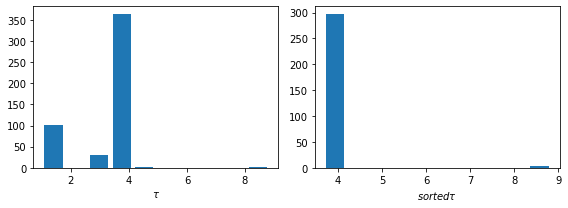

In [6]:
train_data, test_data = initialize_data(train_len=1000)
max_power, min_hidden, min_radius, min_leaky, min_spar, powers = random_grid_search(
    train_data,
    test_data,
    hidden_range=[80, 200],
    radius_range=[0.1, 1.3],
    leaky_range=[0.5, 0.99],
    sparsity_range=[0.1, 0.5],
    num_samples=500,
)
print(f'max_power: {max_power:.2f};\n for hid={min_hidden}, rad={min_radius:.2f}, leak={min_leaky:.2f}, spar={min_spar:.2f}')
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
axs = axs.flatten()
axs[0].hist(powers, rwidth=0.8)
axs[0].set_xlabel(r"$\tau$")
axs[1].hist(sorted(powers)[-300:], rwidth=0.8)
axs[1].set_xlabel(r"$sorted \tau$")
fig.tight_layout()


## Prediction power with noisy observations by LRESN compared with DAESN

no inner noise
harvesting states...
train length 999
mse: 1.9276396010553003
noise level 1.00
harvesting states...
train length 999
mse: 2.0379060864212226


Text(0.5, 1.0, 'DAESN Power 4.47')

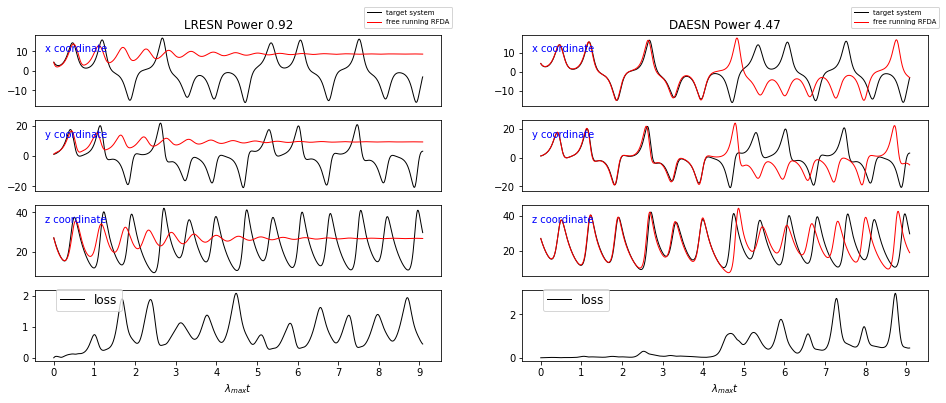

In [20]:
#TODO: tune ridge_param for both LRESN and DAESN with the same noise data.
train_data, test_data = initialize_data(train_len=1000)
esn = Esn(n_inputs=3,
          n_outputs=3,
          n_reservoir=92,
          leaky_rate=0.987,
          spectral_radius=0.148,
          random_state=None,
          sparsity=0.4,
          silent=False,
         ridge_param=1e-5)

test_inputs, test_targets = test_data[:, :], test_data[:, 1:]
test_length = test_targets.shape[1]

eta = 1.
dt = 0.01
noise_train_data = train_data + np.random.multivariate_normal(np.zeros(3), np.eye(3) * eta, size=train_data.shape[1]).T
esn.fit(noise_train_data)
prediction = esn.forward(test_inputs[:, 0], n_iteration=test_length)
pred_power = prediction_power(test_targets, prediction)
loss = distance(test_targets, prediction)

print(f'noise level {eta:.2f}')
# print(f'maxium prediction time {pred_power:.2f}')

lyapunov_exp = 0.91
max_time_unit = int(test_length * dt / lyapunov_exp)
time_ticks = [l / lyapunov_exp / dt for l in range(max_time_unit)]
fig, ax = plt.subplots(4, 2, figsize=(16, 6))
coords = ["x coordinate", "y coordinate", "z coordinate"]

for i in range(3):
    ax[i, 0].plot(range(test_length), test_targets[i, :], 'k', lw=1, label="target system")
    ax[i, 0].plot(range(test_length), prediction[i, :], 'r', lw=1, label="free running RFDA")
    ax[i, 0].set_xticks([])
    ax[i, 0].text(0.1, 0.8, coords[i], fontsize=10, ha='center', va='center', color='b', transform=ax[i, 0].transAxes)
ax[3, 0].plot(range(test_length), loss, 'k', lw=1, label="loss")
ax[3, 0].legend(loc=(0.05, 0.7), fontsize=12)
ax[0, 0].legend(loc=(0.81, 1.1), fontsize='x-small')
ax[3, 0].set_xticks(time_ticks)
ax[3, 0].set_xticklabels(np.arange(max_time_unit))
ax[3, 0].set_xlabel('$ \lambda_{max}t $')
ax[0, 0].set_title(f"LRESN Power {pred_power:.2f}")


esn = Esn(n_inputs=3,
          n_outputs=3,
          n_reservoir=92,
          leaky_rate=0.987,
          spectral_radius=0.148,
          random_state=None,
          sparsity=0.4,
          silent=False,
         ridge_param=1e-3)
esn.fit_da(noise_train_data, None, ensembles=500, eta=eta, gamma=1000., initial_zero=False)
prediction = esn.forward(test_inputs[:, 0], n_iteration=test_length)
pred_power = prediction_power(test_targets, prediction)
loss = distance(test_targets, prediction)

for i in range(3):
    ax[i, 1].plot(range(test_length), test_targets[i, :], 'k', lw=1, label="target system")
    ax[i, 1].plot(range(test_length), prediction[i, :], 'r', lw=1, label="free running RFDA")
    ax[i, 1].set_xticks([])
    ax[i, 1].text(0.1, 0.8, coords[i], fontsize=10, ha='center', va='center', color='b', transform=ax[i, 1].transAxes)
ax[3, 1].plot(range(test_length), loss, 'k', lw=1, label="loss")
ax[3, 1].legend(loc=(0.05, 0.7), fontsize=12)
ax[0, 1].legend(loc=(0.81, 1.1), fontsize='x-small')
ax[3, 1].set_xticks(time_ticks)
ax[3, 1].set_xticklabels(np.arange(max_time_unit))
ax[3, 1].set_xlabel('$ \lambda_{max}t $')
ax[0, 1].set_title(f"DAESN Power {pred_power:.2f}")


## Denpendence analysis for LRESN

dependence data shape: (100, 100, 100)


Text(0.5, 1.0, 'std_power')

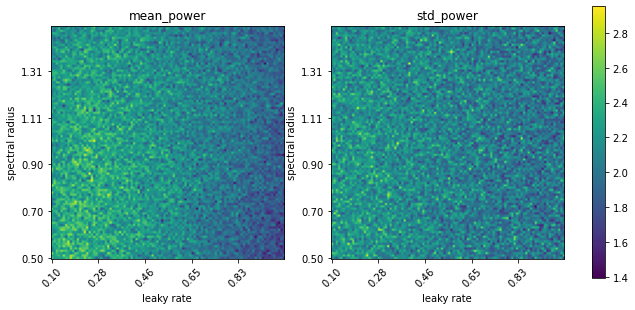

In [13]:
dependence_data = np.load("../Data/dependece_leak_spectral_lr.npz")
res = dependence_data["res"]
leaks = dependence_data["leaks"]
spectrals = dependence_data["spectrals"]
print("dependence data shape:", res.shape)
mean_res = res.mean(axis=2)
std_res = res.std(axis=2)
# mean_res_vis = mean_res.copy()
# mean_res_vis[mean_res_vis<1.5] = 0.
# mean_res_vis = (mean_res_vis - np.min(mean_res_vis)) / (np.max(mean_res_vis) - np.min(mean_res_vis))
# mean_res_vis = np.log(mean_res_vis)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax = ax.flatten()
im = ax[0].imshow(mean_res)
ax[1].imshow(std_res)
fig.colorbar(im, ax=[ax[0], ax[1]], fraction=0.03, pad=0.05)
# ax[2].imshow(mean_res_vis)
leaks = [f'{leak:.2f}' for leak in leaks[[0, 20, 40, 60, 80]]]
spectrals = [f'{spectral:.2f}' for spectral in spectrals[[0, 20, 40, 60, 80]]]
for i in range(2):
    ax[i].set_xticks([0, 20, 40, 60, 80])
    ax[i].set_xticklabels(leaks, rotation=45)
    ax[i].set_xlabel("leaky rate")
    ax[i].set_yticks([0, 20, 40, 60, 80])
    ax[i].set_yticklabels(spectrals)
    ax[i].set_ylabel("spectral radius")
    ax[i].invert_yaxis()
ax[0].set_title("mean_power")
ax[1].set_title("std_power")

    
    

## Denpendence analysis for DAESN

dependence data shape: (100, 100, 100)


Text(0.5, 1.0, 'std_power')

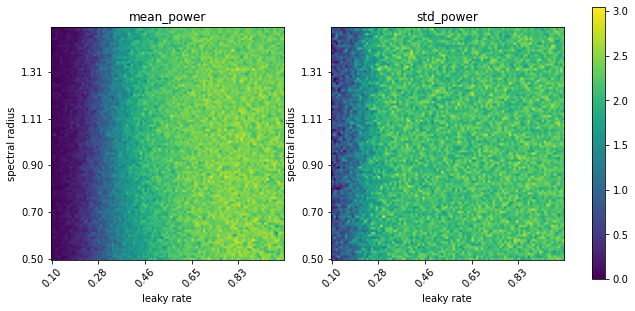

In [16]:
dependence_data = np.load("../Data/dependece_leak_spectral_da.npz")
res = dependence_data["res"]
leaks = dependence_data["leaks"]
spectrals = dependence_data["spectrals"]
print("dependence data shape:", res.shape)
mean_res = res.mean(axis=2)
std_res = res.std(axis=2)
# mean_res_vis = mean_res.copy()
# mean_res_vis[mean_res_vis<1.5] = 0.
# mean_res_vis = (mean_res_vis - np.min(mean_res_vis)) / (np.max(mean_res_vis) - np.min(mean_res_vis))
# mean_res_vis = np.log(mean_res_vis)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax = ax.flatten()
im = ax[0].imshow(mean_res)
ax[1].imshow(std_res)
fig.colorbar(im, ax=[ax[0], ax[1]], fraction=0.03, pad=0.05)
# ax[2].imshow(mean_res_vis)
leaks = [f'{leak:.2f}' for leak in leaks[[0, 20, 40, 60, 80]]]
spectrals = [f'{spectral:.2f}' for spectral in spectrals[[0, 20, 40, 60, 80]]]
for i in range(2):
    ax[i].set_xticks([0, 20, 40, 60, 80])
    ax[i].set_xticklabels(leaks, rotation=45)
    ax[i].set_xlabel("leaky rate")
    ax[i].set_yticks([0, 20, 40, 60, 80])
    ax[i].set_yticklabels(spectrals)
    ax[i].set_ylabel("spectral radius")
    ax[i].invert_yaxis()
ax[0].set_title("mean_power")
ax[1].set_title("std_power")

harvesting states...
train length 999
mse: 1.820328891843905

noise level 1.00
maxium prediction time 2.39


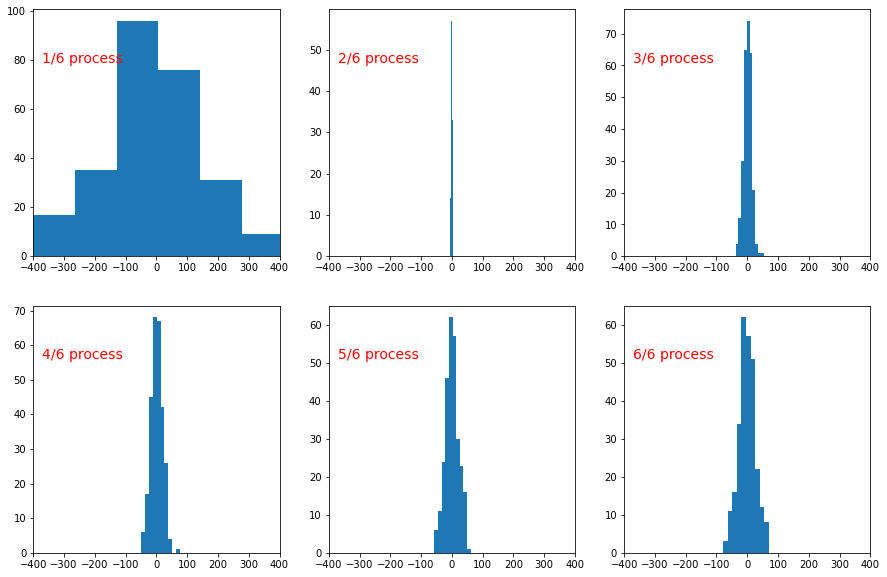

In [15]:
esn = Esn(n_inputs=3,
          n_outputs=3,
          n_reservoir=92,
          leaky_rate=0.987,
          spectral_radius=0.148,
          random_state=None,
          sparsity=0.4,
          silent=False)


test_inputs, test_targets = test_data[:, :], test_data[:, 1:]
test_length = test_targets.shape[1]

eta = 1.
noise_train_data = train_data + np.random.multivariate_normal(np.zeros(3), np.eye(3) * eta, size=train_data.shape[1]).T
_, total_W = esn.fit_da(noise_train_data, None, ensembles=500, eta=eta, gamma=1000., initial_zero=False, return_total_Wlr=True)
prediction = esn.forward(test_inputs[:, 0], n_iteration=test_length)
pred_power = prediction_power(test_targets, prediction)
print(f'\nnoise level {eta:.2f}')
print(f'maxium prediction time {pred_power:.2f}')
num, n_output, n_reservoir = total_W.shape
fig = plt.figure(figsize=(15, 10))
for i in range(num):
    ax = fig.add_subplot(2,3,i+1)
#     variance = total_W[i].std()
#     bins = int(variance / 800 * 50)
    ax.hist(total_W[i].reshape(-1), label=f"{i+1}//{num}")
#     ax.legend(loc=(0.55, 0.6), fontsize='12')
    ax.text(0.2, 0.8, f"{i+1}/{num} process", fontsize=14, ha='center', va='center', color='r', transform=ax.transAxes)
    ax.set_xlim([-400, 400])

plt.show()


# inner noise polluted data drive the reservoir system

with inner noise
harvesting states...
train length 999
mse: 1.8923286395831462
noise level 1.00
harvesting states...
train length 999
mse: 1.9812961463205423


Text(0.5, 1.0, 'DAESN Power 1.04')

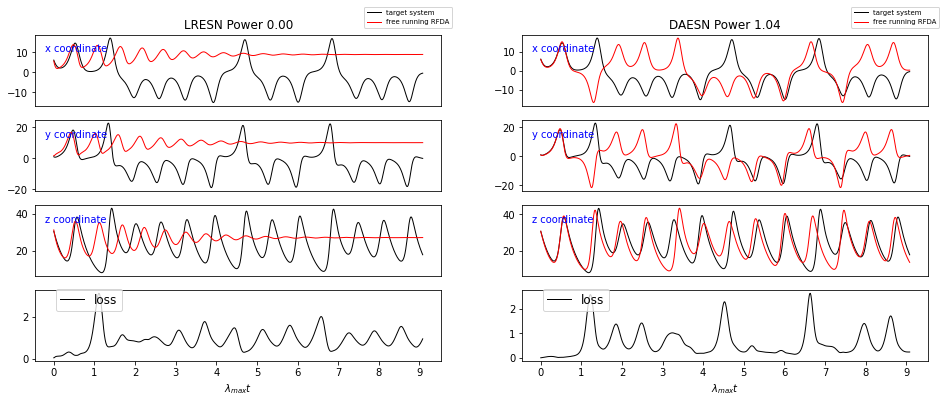

In [26]:

train_data, test_data = initialize_data(train_len=1000, noise=0.2)
esn = Esn(n_inputs=3,
          n_outputs=3,
          n_reservoir=92,
          leaky_rate=0.987,
          spectral_radius=0.148,
          random_state=None,
          sparsity=0.4,
          silent=False,
         ridge_param=1e-5)

test_inputs, test_targets = test_data[:, :], test_data[:, 1:]
test_length = test_targets.shape[1]


dt = 0.01
eta = 1.
noise_train_data = train_data + np.random.multivariate_normal(np.zeros(3), np.eye(3) * eta, size=train_data.shape[1]).T
esn.fit(noise_train_data)
prediction = esn.forward(test_inputs[:, 0], n_iteration=test_length)
pred_power = prediction_power(test_targets, prediction)
loss = distance(test_targets, prediction)

print(f'noise level {eta:.2f}')
# print(f'maxium prediction time {pred_power:.2f}')

lyapunov_exp = 0.91
max_time_unit = int(test_length * dt / lyapunov_exp)
time_ticks = [l / lyapunov_exp / dt for l in range(max_time_unit)]
fig, ax = plt.subplots(4, 2, figsize=(16, 6))
coords = ["x coordinate", "y coordinate", "z coordinate"]

for i in range(3):
    ax[i, 0].plot(range(test_length), test_targets[i, :], 'k', lw=1, label="target system")
    ax[i, 0].plot(range(test_length), prediction[i, :], 'r', lw=1, label="free running RFDA")
    ax[i, 0].set_xticks([])
    ax[i, 0].text(0.1, 0.8, coords[i], fontsize=10, ha='center', va='center', color='b', transform=ax[i, 0].transAxes)
ax[3, 0].plot(range(test_length), loss, 'k', lw=1, label="loss")
ax[3, 0].legend(loc=(0.05, 0.7), fontsize=12)
ax[0, 0].legend(loc=(0.81, 1.1), fontsize='x-small')
ax[3, 0].set_xticks(time_ticks)
ax[3, 0].set_xticklabels(np.arange(max_time_unit))
ax[3, 0].set_xlabel('$ \lambda_{max}t $')
ax[0, 0].set_title(f"LRESN Power {pred_power:.2f}")

esn = Esn(n_inputs=3,
          n_outputs=3,
          n_reservoir=92,
          leaky_rate=0.987,
          spectral_radius=0.148,
          random_state=None,
          sparsity=0.4,
          silent=False,
         ridge_param=1e-3)
esn.fit_da(noise_train_data, None, ensembles=500, eta=eta, gamma=1000., initial_zero=False)
prediction = esn.forward(test_inputs[:, 0], n_iteration=test_length)
pred_power = prediction_power(test_targets, prediction)
loss = distance(test_targets, prediction)

for i in range(3):
    ax[i, 1].plot(range(test_length), test_targets[i, :], 'k', lw=1, label="target system")
    ax[i, 1].plot(range(test_length), prediction[i, :], 'r', lw=1, label="free running RFDA")
    ax[i, 1].set_xticks([])
    ax[i, 1].text(0.1, 0.8, coords[i], fontsize=10, ha='center', va='center', color='b', transform=ax[i, 1].transAxes)
ax[3, 1].plot(range(test_length), loss, 'k', lw=1, label="loss")
ax[3, 1].legend(loc=(0.05, 0.7), fontsize=12)
ax[0, 1].legend(loc=(0.81, 1.1), fontsize='x-small')
ax[3, 1].set_xticks(time_ticks)
ax[3, 1].set_xticklabels(np.arange(max_time_unit))
ax[3, 1].set_xlabel('$ \lambda_{max}t $')
ax[0, 1].set_title(f"DAESN Power {pred_power:.2f}")
